In [1]:
# References: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
# https://medium.com/@masarudheena/4-best-ways-to-find-optimal-number-of-clusters-for-clustering-with-python-code-706199fa957c
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
wine = load_wine()

In [2]:
wine = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

In [3]:
wine.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'target'],
      dtype='object')

In [4]:
from sklearn.preprocessing import StandardScaler

# features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = wine.drop(labels='target',axis=1)
# Separating out the target
y = wine['target']
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [6]:
finalDf = pd.concat([principalDf, wine[['target']]], axis = 1)

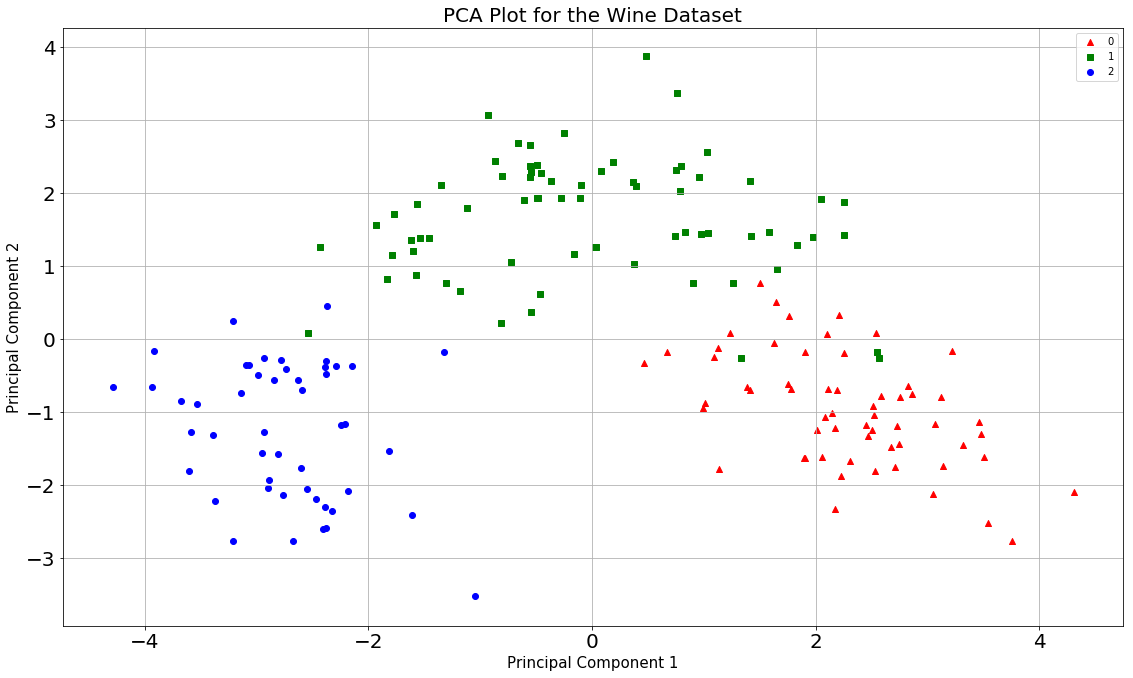

In [7]:
# Reference Source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (19,11))
ax = fig.add_subplot(1,1,1) 
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Plot for the Wine Dataset', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
markers = ["^" , "," , "o"]
#########################################################################################
#marker and color bank
#markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
#colors = ['r','g','b','c','m', 'y', 'k']
#########################################################################################
for target, color, marker in zip(targets,colors,markers):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , marker = marker
               )
ax.legend(targets)
ax.grid()

In [8]:
# variance explained
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 ])

In [9]:
# factor loading
pca.components_

array([[ 0.1443294 , -0.24518758, -0.00205106, -0.23932041,  0.14199204,
         0.39466085,  0.4229343 , -0.2985331 ,  0.31342949, -0.0886167 ,
         0.29671456,  0.37616741,  0.28675223],
       [-0.48365155, -0.22493093, -0.31606881,  0.0105905 , -0.299634  ,
        -0.06503951,  0.00335981, -0.02877949, -0.03930172, -0.52999567,
         0.27923515,  0.16449619, -0.36490283]])

In [10]:
# k-mean
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(principalDf)
y_kmeans = kmeans.predict(principalDf)

Text(0.5, 1.0, 'K-means clustering')

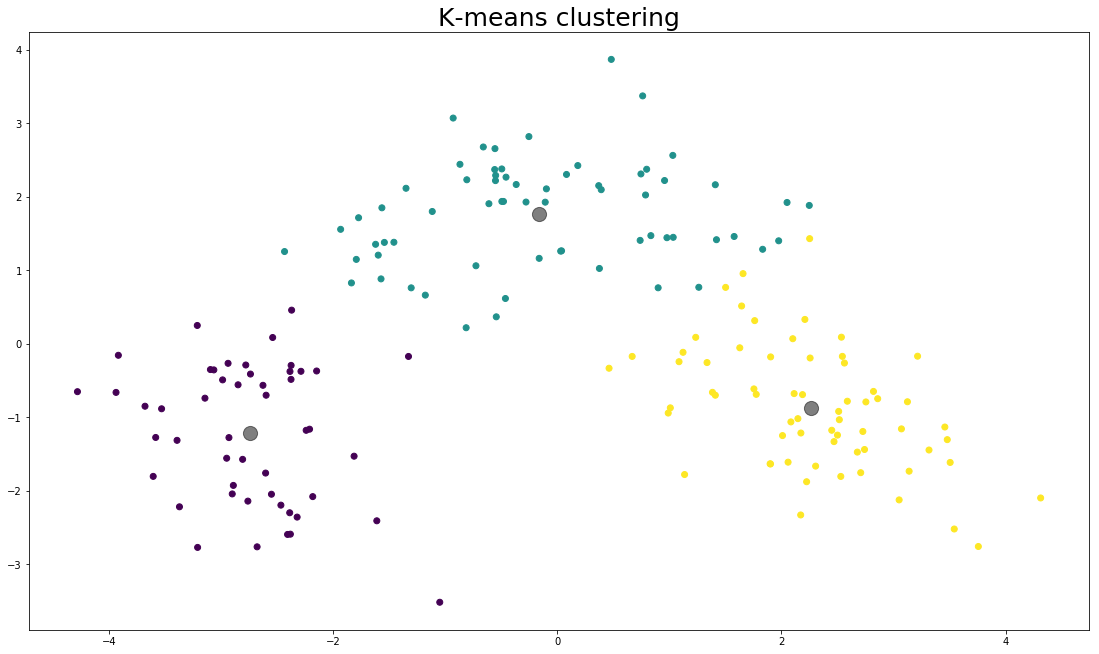

In [15]:
fig = plt.figure(figsize = (19,11))
ax = fig.add_subplot(1,1,1)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=y_kmeans)
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
ax.set_title('K-means clustering',fontsize=25)

In [16]:
kmeans.cluster_centers_

array([[-2.74392982, -1.2141906 ],
       [-0.16278513,  1.76758824],
       [ 2.26614991, -0.86559213]])

In [17]:
pd.DataFrame(y_kmeans)[0].value_counts()

1    65
2    64
0    49
Name: 0, dtype: int64

In [18]:
# the "elbow" method
def elbow(x, kmax):
    '''
    This function calculates the total sum of squared errors from the k-means to determine the "elbow" for optimal number of clusters
    x is the input dataset
    kmax is the maximum number of clusters that will be tested
    This function only works for 2-d situation
    '''
    sse = [None]
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(x)
        curr_sse = 0

    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(x)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (x.iloc[i][0] - curr_center[0]) ** 2 + (x.iloc[i][1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

Text(0.5, 1.0, 'Sum of squared error by number of clusters')

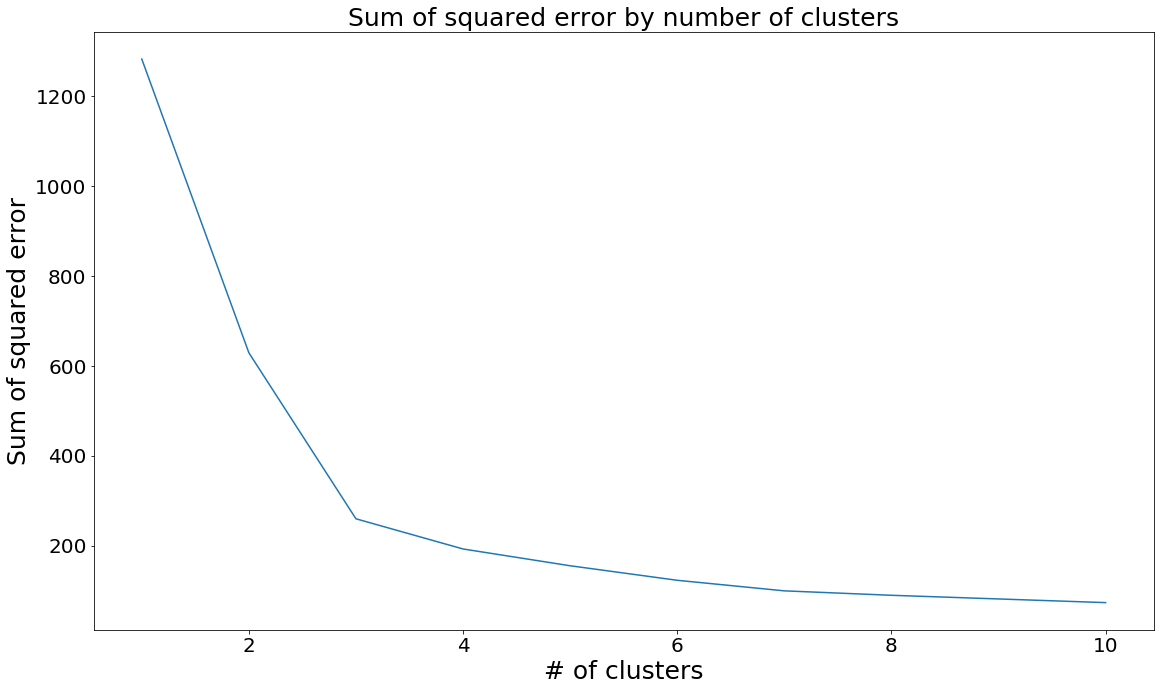

In [19]:
fig = plt.figure(figsize = (19,11))
ax = fig.add_subplot(1, 1, 1)
ax.plot(elbow(principalDf,10))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel('# of clusters',fontsize=25)
ax.set_ylabel('Sum of squared error',fontsize=25)
ax.set_title('Sum of squared error by number of clusters',fontsize=25)

In [20]:
# the "Silhouette" method
from sklearn.metrics import silhouette_score

def Silhouette(x, kmax):
    '''
    This function calculates the Silhouette score from the k-means to determine the "elbow" for optimal number of clusters
    x is the input dataset
    kmax is the maximum number of clusters that will be tested
    This function only works for 2-d situation
    The Silhouette function only works for two or more clusters
    '''
    sil = [None, None]
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    return sil

Text(0.5, 1.0, 'Silhouette score by number of clusters')

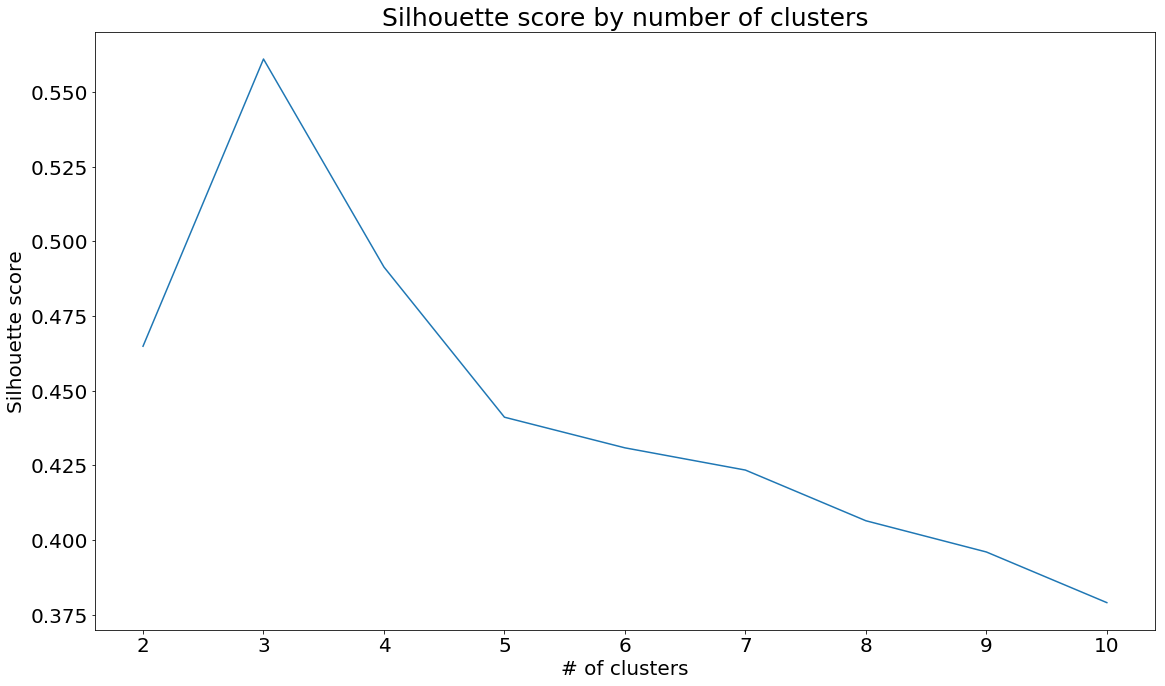

In [21]:
fig = plt.figure(figsize=(19,11))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.plot(Silhouette(principalDf,10))
ax.set_xlabel('# of clusters',fontsize=20)
ax.set_ylabel('Silhouette score',fontsize=20)
ax.set_title('Silhouette score by number of clusters',fontsize=25)

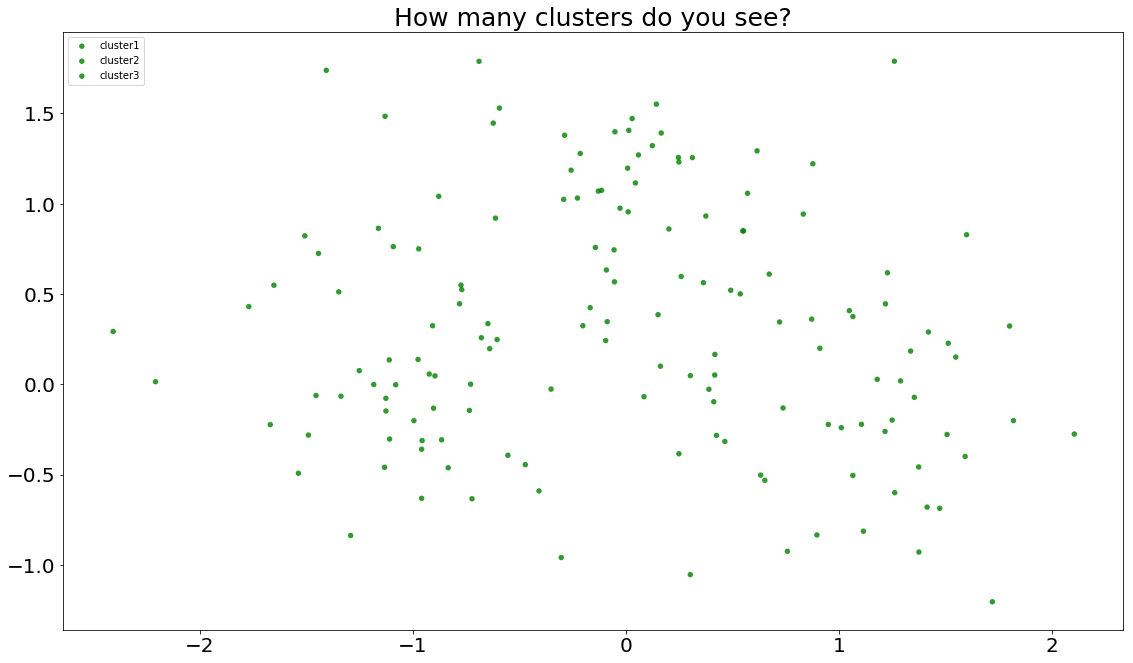

In [22]:
# Visulization how many clusters in a dataset

# Create data
N = 50
g1 = (1 + 0.5 * np.random.normal(0,1,N), 0.5 * np.random.normal(0,1,N))
g2 = (0.5 * np.random.normal(0,1,N), 1 + 0.5*np.random.normal(0,1,N))
g3 = (-1 + 0.5*np.random.normal(0,1,N), 0.5*np.random.normal(0,1,N))

data = (g1, g2, g3)
colors = ("green", "green", "green")
groups = ("cluster1", "cluster2", "cluster3")

# Create plot
fig = plt.figure(figsize = (19,11))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both', which='major', labelsize=20)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('How many clusters do you see?',fontsize=25)
plt.legend(loc=2)
plt.show()
%matplotlib inline
#%matplotlib notebook
#%matplotlib widgets
#%matplotlib tk

#plt.savefig('cluster1.png')

In [ ]:
# test